In [1]:
import os

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# importing all the required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import IPython.display as ipd

In [6]:
from torchvision import transforms
from tqdm import tqdm

In [7]:
import glob
from PIL import Image

In [8]:
visual_images_path = '/content/visual_frames_final'
all_image_files = sorted(glob.glob('/content/visual_frames_final/*/*.jpg'))

In [9]:
all_audio_files = sorted(glob.glob('/content/Audio*/*/*.wav'))

In [10]:
# from tqdm import tqdm

# IMAGES = []
# for impath in tqdm(image_files):
#   img = Image.open(impath)
#   IMAGES.append(img)

In [11]:
len(all_audio_files), len(all_image_files)

(2496, 62042)

In [12]:
label_to_emotion = {'01':'neutral', 
                    '02': 'calm', 
                    '03': 'happy',
                    '04': 'sad',
                    '05': 'angry',
                    '06': 'fearful',
                    '07': 'disgust',
                    '08': 'surprised'}

In [13]:
FILES = {'filepath':[], 
         'label':[], 
         'emotion': [],
         'actor':[], 
         'intensity': [], 
         'duration': [],
         'image_paths': []}
want_duration = False
for wav_file in tqdm(all_audio_files):
  filename = wav_file.replace('.wav', '')
  label = os.path.basename(filename).split('-')[2]
  intensity = os.path.basename(filename).split('-')[3]
  actor = os.path.basename(filename).split('-')[-1]
  
  # filling the dictionary
  FILES['filepath'].append(wav_file)
  FILES['label'].append(label)
  FILES['emotion'].append(label_to_emotion[label])
  FILES['actor'].append(actor)
  FILES['intensity'].append(intensity)
  if want_duration:
    FILES['duration'].append(librosa.get_duration(filename=wav_file))
  else:
    FILES['duration'].append(0.0)
  
  # for video face extraction
  video_file = wav_file
  vid_tag = "=".join(video_file.split('/')[-2:]).replace('.wav', '')
  label = os.path.basename(video_file).split('-')[2]
  label_dir = os.path.join(visual_images_path, label)

  savepath = os.path.join(label_dir, f'{vid_tag}=*.jpg').replace('=03-', '=01-')
  imgpaths = sorted(glob.glob(savepath)) or 'NAH'

  FILES['image_paths'].append(imgpaths)


100%|██████████| 2496/2496 [00:25<00:00, 98.21it/s]


In [14]:
df = pd.DataFrame(FILES)
df

,filepath,label,emotion,actor,intensity,duration,image_paths
0,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
1,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
2,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
3,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
4,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,02,calm,01,01,0.0,[/content/visual_frames_final/02/Actor_01=01-0...
...,...,...,...,...,...,...,...
2491,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,01,0.0,[/content/visual_frames_final/08/Actor_24=01-0...
2492,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,02,0.0,[/content/visual_frames_final/08/Actor_24=01-0...
2493,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,02,0.0,[/content/visual_frames_final/08/Actor_24=01-0...
2494,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,02,0.0,[/content/visual_frames_final/08/Actor_24=01-0...


In [15]:
# df.iloc[0].image_paths

In [16]:
from collections import Counter

Counter(df.emotion)

Counter({'angry': 384,
         'calm': 384,
         'disgust': 192,
         'fearful': 384,
         'happy': 384,
         'neutral': 192,
         'sad': 384,
         'surprised': 192})

In [17]:
# to split the data into training and validation
from sklearn.model_selection import train_test_split

In [18]:
train_df, dev_df = train_test_split(df, shuffle=True, stratify=df['label'], test_size=0.15, random_state=6)
dev_df, test_df = train_test_split(dev_df, shuffle=True, stratify=dev_df['label'], test_size=0.5, random_state=6)

train_df.shape, dev_df.shape, test_df.shape

((2121, 7), (187, 7), (188, 7))

In [19]:
train_df = train_df[train_df.image_paths!='NAH']
dev_df = dev_df[dev_df.image_paths!='NAH']
test_df = test_df[test_df.image_paths!='NAH']

train_df.shape, dev_df.shape, test_df.shape

((2075, 7), (183, 7), (184, 7))

In [20]:
print(Counter(train_df.emotion))
print(Counter(dev_df.emotion))
print(Counter(test_df.emotion))

Counter({'sad': 321, 'fearful': 320, 'happy': 319, 'angry': 319, 'calm': 316, 'surprised': 163, 'disgust': 163, 'neutral': 154})
Counter({'happy': 29, 'angry': 28, 'sad': 28, 'calm': 28, 'fearful': 27, 'disgust': 15, 'surprised': 15, 'neutral': 13})
Counter({'angry': 29, 'fearful': 29, 'calm': 29, 'happy': 28, 'sad': 27, 'neutral': 14, 'surprised': 14, 'disgust': 14})


In [21]:
SAMPLE_RATE = 16000
NMFCCs = 13

In [ ]:
# t = 13
# r = 3
# kk = np.arange(t)
# for i in range(0, t, r):
#   kk_ = kk[i:i+r]
#   if len(kk_)!=r:
#     kk_ = kk[i - r + len(kk_):]
#   print(kk_)

In [22]:
!pip install torchaudio

In [23]:
import torchaudio

In [38]:
# as a method to deal with overfitting from the previous model;
# we are adding specaug for audio and image transformation for video
# audio transforms
train_audio_transforms = torch.nn.Sequential(torchaudio.transforms.FrequencyMasking(freq_mask_param=3),
                                             torchaudio.transforms.FrequencyMasking(freq_mask_param=3),
                                             torchaudio.transforms.TimeMasking(time_mask_param=15),
                                             torchaudio.transforms.TimeMasking(time_mask_param=15))
test_audio_transforms = None

print("Audio transforms...")
print(train_audio_transforms)
print(test_audio_transforms)

# video transforms
train_vision_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                              transforms.RandomAffine((-5, 5)),
                                              transforms.ColorJitter(),
                                              transforms.RandomPerspective(0.1),
                                              # transforms.RandomGrayscale(p=0.1),
                                              # transforms.CenterCrop(58),
                                              # transforms.Resize((64, 64)),
                                              transforms.ToTensor(),
                                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


test_vision_transforms = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
print("Vision transforms...")
print(train_vision_transforms)
print(test_vision_transforms)


Audio transforms...
Sequential(
  (0): FrequencyMasking()
  (1): FrequencyMasking()
  (2): TimeMasking()
  (3): TimeMasking()
)
None
Vision transforms...
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomAffine(degrees=[-5.0, 5.0])
    ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
    RandomPerspective(p=0.5)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


In [39]:
class AudioVideoDatasetV2(torch.utils.data.Dataset):
  def __init__(self, df, audio_transforms, video_transforms):
    self.df = df
    self.audio_transforms = audio_transforms
    self.video_transforms = video_transforms
    self.duration_required = 2 #2seconds
    self.images_required = 4
    self.audio_data = {}
    self.video_data = {}
    # load all the audio files and convert them into spectrograms 
    print("Loading all the audio and video files on to RAM...")
    self.DATAHANDLES = []

    for lineno in tqdm(range(self.df.shape[0])):
      line = self.df.iloc[lineno]
      wavpath = line.filepath
      audio_duration = librosa.get_duration(filename=wavpath)
      audio, sr = librosa.load(wavpath, 
                             sr=SAMPLE_RATE, 
                             duration=self.duration_required, 
                             offset=audio_duration/2 - self.duration_required/2)
      mel_spec = librosa.feature.mfcc(audio, sr=SAMPLE_RATE, n_mfcc=NMFCCs)
      self.audio_data[wavpath] = mel_spec

      for imgpath in line.image_paths:
        img = Image.open(imgpath)
        self.video_data[imgpath] = img

      for ino in range(0, len(line.image_paths), self.images_required):
        imgs = line.image_paths[ino:ino+self.images_required]
        # print("LEN", len(imgs), len(line.image_paths))
        if len(imgs) != self.images_required:
          imgs = line.image_paths[max(0, ino - self.images_required - len(imgs)):]
          # print("broke len", len(imgs), len(line.image_paths))
        if len(imgs) != self.images_required: 
          # print("Assertion failed for ", lineno)
          continue
        self.DATAHANDLES.append({'label':line.label, 'audio':line.filepath, 'video':imgs})

    print(f"Done loading: Audio data: {len(self.audio_data)}\tVideo files: {len(self.video_data)}")
    print(f"Total Samples here: {len(self.DATAHANDLES)}")

  def __len__(self):
    return len(self.DATAHANDLES)

  def __getitem__(self, idx):
    line = self.DATAHANDLES[idx]
    label = int(line['label']) - 1
    mel_spec = torch.Tensor(self.audio_data[line['audio']])
    images = torch.cat([self.video_transforms(self.video_data[x]) for x in line['video']], dim=2)
    if self.audio_transforms is not None:
      mel_spec_tensor = self.audio_transforms(torch.Tensor(mel_spec))
    else:
      mel_spec_tensor = torch.Tensor(mel_spec)
    return mel_spec_tensor , images, torch.Tensor([label])

In [43]:
train_dataset = AudioVideoDatasetV2(train_df, train_audio_transforms, train_vision_transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               shuffle=True, 
                                               batch_size=128, 
                                               num_workers=8)


dev_dataset = AudioVideoDatasetV2(dev_df, test_audio_transforms, test_vision_transforms)
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, 
                                             shuffle=False, 
                                             batch_size=32, 
                                             num_workers=8)


test_dataset = AudioVideoDatasetV2(test_df, test_audio_transforms, test_vision_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                             shuffle=False, 
                                             batch_size=32, 
                                             num_workers=8)




Loading all the audio and video files on to RAM...


100%|██████████| 2075/2075 [04:17<00:00,  8.07it/s]


Done loading: Audio data: 2075	Video files: 26316
Total Samples here: 5705
Loading all the audio and video files on to RAM...


100%|██████████| 183/183 [00:22<00:00,  8.11it/s]


Done loading: Audio data: 183	Video files: 2314
Total Samples here: 498
Loading all the audio and video files on to RAM...


100%|██████████| 184/184 [00:22<00:00,  8.11it/s]

Done loading: Audio data: 184	Video files: 2333
Total Samples here: 505


In [45]:
for i, batch in enumerate(train_dataloader):
  audio, video, label = batch
  break

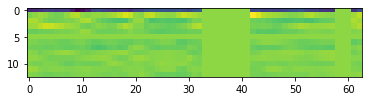

In [46]:
plt.imshow(audio[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


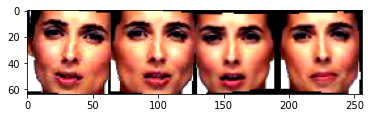

In [50]:
plt.imshow(video[0].permute(1, 2, 0)/2 + 0.5)

In [51]:
print(len(train_dataset), len(dev_dataset), len(test_dataset))
print(len(train_dataloader), len(dev_dataloader), len(test_dataloader))

5705 498 505
45 16 16


In [52]:
# audio model for our multimodal training
class BasicAudioRnnModel(torch.nn.Module):
  def __init__(self, input_size=128, hidden_size=512,num_layers=3, isBidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.linearIn = 2*hidden_size if isBidirectional else hidden_size
    self.rnn = torch.nn.GRU(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers,
                            batch_first=True, 
                            dropout = 0.3, #only for GRU and LSTM not for RNN
                            bidirectional=isBidirectional) #Test with unidirectional
    # self.linear = torch.nn.Linear(self.linearIn, num_classes) 
    self.out_shape = self.linearIn
  def forward(self, X):
    out, h = self.rnn(X)
    out_required = out[:, -1, :]
    # yhat = self.linear(out_required)
    return out_required

In [53]:
def get_padding_dims_same(in_height=64, in_width=64, filter_height=3, filter_width=3, strides=(None, 1, 1)):
    out_height = np.ceil(float(in_height) / float(strides[1]))
    out_width  = np.ceil(float(in_width) / float(strides[2]))

    if (in_height % strides[1] == 0): pad_along_height = max(filter_height - strides[1], 0)
    else: pad_along_height = max(filter_height - (in_height % strides[1]), 0)
    if (in_width % strides[2] == 0): pad_along_width = max(filter_width - strides[2], 0)
    else: pad_along_width = max(filter_width - (in_width % strides[2]), 0)
    pad_top = pad_along_height // 2; pad_bottom = pad_along_height - pad_top; pad_left = pad_along_width // 2
    pad_right = pad_along_width - pad_left
    return (pad_left + pad_right)//2, (pad_top + pad_bottom)//2
    return (pad_left, pad_right, pad_top, pad_bottom)

def get_output_size_convs(H, W, KW, KH, S, P):
    outputW = 1 + (W - KW + 2*P)//S
    outputH = 1 + (H - KH + 2*P)//S
    return outputW, outputH

In [54]:

class ResBlock(nn.Module):
    def __init__(self, W, H, params):
        super().__init__()
        self.params = params
        padding_dims1 = get_padding_dims_same(W, H, 
                                              params[0]['kernel_size'], 
                                              params[0]['kernel_size'],
                                              (None, params[0]['stride'], params[0]['stride']))
        self.conv1 = nn.Conv2d(params[0]['in_channels'], 
                               params[0]['out_channels'], 
                               kernel_size=params[0]['kernel_size'], 
                               stride=params[0]['stride'],
                               padding=padding_dims1)
        self.bn1 = nn.BatchNorm2d(params[0]['out_channels'])
        self.relu = nn.ReLU()
        
        padding_dims2 = get_padding_dims_same(W, H, 
                                              params[0]['kernel_size'], 
                                              params[0]['kernel_size'],
                                              (None, params[0]['stride'], params[0]['stride']))
        
        
        self.conv2 = nn.Conv2d(params[1]['in_channels'], 
                               params[1]['out_channels'], 
                               kernel_size=params[1]['kernel_size'], 
                               stride=params[1]['stride'],
                               padding=padding_dims2)
        self.bn2 = nn.BatchNorm2d(params[1]['out_channels'])
        if params[1]['channel_resizer']:
            self.channel_resizer = nn.Conv2d(params[0]['in_channels'], params[1]['out_channels'], kernel_size=1, stride=1)
        else:
            self.channel_resizer = nn.Identity()
        
    def forward(self, X):
        IN = X
#         print("0", X.shape)
        
        out = self.conv1(X)
#         print("1", out.shape)
        
        out = self.bn1(out)
#         print("2", out.shape)
        
        out = self.relu(out)
#         print("3", out.shape)
        
        out = self.conv2(out)
#         print("4", out.shape)
        IN = self.channel_resizer(IN)
#         print("5", IN.shape)
        
        out += IN
#         print("6", out.shape)
        return self.relu(out)

    
class NormalConvBlock(nn.Module):
    def __init__(self, W=64, H=64, params=None):
        super().__init__()
        self.params = params
        self.W = W
        self.H = H
        self.conv1 = nn.Conv2d(params['in_channels'], 
                               params['out_channels'],
                              kernel_size=params['kernel_size'],
                              stride=params['stride'])
        self.pool = nn.AvgPool2d(kernel_size=params['pool_kernel_size'], 
                                   stride=params['pool_stride'])
        self.relu = nn.ReLU()

    def forward(self, X):
        out = self.conv1(X)
        out = self.pool(out)
        out = self.relu(out)
        return out
    def get_output_size(self):
        w, h = get_output_size_convs(self.W, self.H, 
                                     self.params['kernel_size'], self.params['kernel_size'],
                                     self.params['stride'], 0)
        w, h = get_output_size_convs(w, h, 
                                     self.params['pool_kernel_size'], self.params['pool_kernel_size'],
                                     self.params['pool_stride'], 0)
        return self.params['out_channels'], w, h


class MyVideoSimpleModel(nn.Module):
    def __init__(self, W=64, H=64, hyperparameters=None, classes=4000):
        super().__init__()
        normal_params = hyperparameters['normal_params']
        resnet_params = hyperparameters['resnet_params']
        n_resnet_blocks = hyperparameters['n_resnet_blocks']
        
        layers = []
        
        w, h = W, H
        for i, n_params in enumerate(normal_params):
            layers.append(NormalConvBlock(w, h, n_params))
            c, w, h = layers[-1].get_output_size()
            print(c, w, h)
            
        print(f"Normal Inputs to ResBlocks: W: {w} H: {h}")
        
        for i in range(n_resnet_blocks):
            layers.append(ResBlock(W, H, resnet_params))
        
        self.net = nn.Sequential(*layers)
        self.flatten = nn.Flatten()
        
        self.out_shape = c*w*h
        
        # self.linear1 = nn.Linear(c*w*h, 1500)
        # self.tanh = nn.Tanh()
        # self.linear2 = nn.Linear(1500, classes)

    def forward(self, X, form='nlwc', return_bn=False):
        if form=='nlwc':
            X = X.permute(0, 3, 1, 2)
        out = self.net(X)
        out = self.flatten(out)
        # out = self.linear1(out)
        # out = self.tanh(out)
        # self.bottlenecks = out
        # out = self.linear2(out)
        # if return_bn: 
        #         return out, self.bottlenecks
        return out

In [55]:
class AudioVideoMMmodel3(nn.Module):
    def __init__(self, audio_hyperparameters, video_hyperparameters, classes=8):
        super().__init__()
        self.audio_model = BasicAudioRnnModel(audio_hyperparameters['INPUT_SIZE'], 
                                              audio_hyperparameters['N_HIDDEN'], 
                                              audio_hyperparameters['NUM_LAYERS'],  
                                              audio_hyperparameters['IS_BIDIRECTIONAL'])
        
        self.video_model = MyVideoSimpleModel(hyperparameters=video_hyperparameters, W=256, H=64)

        self.in_shape = self.audio_model.out_shape + self.video_model.out_shape
        print(f"Audio Vector Size: {self.audio_model.out_shape}\nVideo Vector Shape: {self.video_model.out_shape}\nConcatenated: {self.in_shape}")
        # self.linear_layer = 
        # self.relu = torch.nn.ReLU()
        self.final_classifier = torch.nn.Linear(self.in_shape, classes)
    def forward(self, audio, video, verbose=False):
      audio_out = self.audio_model(audio)
      video_out = self.video_model(video, form='nclw')
      concatenated_vector = torch.cat([audio_out, video_out], dim=1)
      if verbose:
        print(f"Concatenated vector shape: {concatenated_vector.shape}")
      out = self.final_classifier(concatenated_vector)
      return out

In [95]:
# hyperparameters of my model for easy versioning is stored in a dictionary and later into a yaml file. 

# video model
normal_params = [{'in_channels':3, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2}]

resnet_params = [{'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'channel_resizer':False},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'channel_resizer':False}]
n_resnet_blocks = 10

video_hyperparameters = {'normal_params':normal_params,
                   'resnet_params':resnet_params,
                   'n_resnet_blocks':n_resnet_blocks}

# audio hyperparameters
audio_hyperparameters = {
    'INPUT_SIZE': 13,
    'N_HIDDEN': 512,
    'NUM_LAYERS':4,
    'IS_BIDIRECTIONAL': True
}

full_hyperparameters = {'audio_hyperparameters': audio_hyperparameters, 
                        'video_hyperparameters': video_hyperparameters}        

In [96]:
# audio.shape, video.shape, label.shape
full_hyperparameters

{'audio_hyperparameters': {'INPUT_SIZE': 13,
  'IS_BIDIRECTIONAL': True,
  'NUM_LAYERS': 4,
  'N_HIDDEN': 512},
 'video_hyperparameters': {'n_resnet_blocks': 10,
  'normal_params': [{'in_channels': 3,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1},
   {'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1},
   {'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1},
   {'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1}],
  'resnet_params': [{'channel_resizer': False,
    'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'stride': 1},
   {'channel_resizer': False,
    'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'stride': 1}]}}

In [97]:
DEVICE = 'cuda'

In [98]:
av_model_3 = AudioVideoMMmodel3(audio_hyperparameters, video_hyperparameters)
av_model_3.to(DEVICE)

128 127 31
128 62 14
128 30 6
128 14 2
Normal Inputs to ResBlocks: W: 14 H: 2
Audio Vector Size: 1024
Video Vector Shape: 3584
Concatenated: 4608


AudioVideoMMmodel3(
  (audio_model): BasicAudioRnnModel(
    (rnn): GRU(13, 512, num_layers=4, batch_first=True, dropout=0.3, bidirectional=True)
  )
  (video_model): MyVideoSimpleModel(
    (net): Sequential(
      (0): NormalConvBlock(
        (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (1): NormalConvBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (2): NormalConvBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (3): NormalConvBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (4): ResBlock(
        (co

In [99]:
# outs = av_model_3(audio.permute(0, 2, 1), video, verbose=True)

In [100]:
# outs.shape

In [101]:
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(av_model_3.parameters(), lr=0.001) #initial lr=0.01
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=2)

In [102]:
def get_accuracy(yhat, y):
  return (yhat.argmax(1)==y).float().mean()


def train_one_epoch_audiovideov3(model, dataset, criterion, optim, epoch):
  model.train()
  losses = []
  accus = []
  stime = time.time()
  pbar = tqdm(dataset)
  for i, batch in enumerate(pbar):
    audiofeats = batch[0].to(DEVICE)
    videofeats = batch[1].to(DEVICE)
    labels = batch[2].flatten().to(DEVICE)

    outs = model(torch.permute(audiofeats, (0, 2, 1)), videofeats)

    optim.zero_grad()
    l = criterion(outs, labels.long())
    l.backward()
    optim.step()

    losses.append(l.item())
    accu = get_accuracy(outs, labels)
    accus.append(accu.item())

    accuracy_avg = sum(accus)/len(accus)
    loss_avg = sum(losses)/len(losses)
    pbar.set_description(f"Progress - Accu: {accuracy_avg:.3f}\tLoss: {loss_avg:.3f}")

  etime = time.time()
  accuracy_avg = sum(accus)/len(accus)
  loss_avg = sum(losses)/len(losses)
  time_total = etime - stime
  print(f'\n[TRAIN] Epoch: {epoch}\tAccu: {accuracy_avg}\tLoss: {loss_avg}\tTime: {time_total:.3f} secs')
  return loss_avg, accuracy_avg, time_total

@torch.no_grad()
def evaluate_model(model, dataset, criterion, epoch, subset='VALID'):
  model.eval()
  losses = []
  accus = []
  stime = time.time()
  for i, batch in enumerate(dataset):
    audiofeats = batch[0].to(DEVICE)
    videofeats = batch[1].to(DEVICE)
    labels = batch[2].flatten().to(DEVICE)

    outs = model(torch.permute(audiofeats, (0, 2, 1)), videofeats)

    l = criterion(outs, labels.long())

    losses.append(l.item())
    accu = get_accuracy(outs, labels)
    accus.append(accu.item())
  etime = time.time()
  accuracy_avg = sum(accus)/len(accus)
  loss_avg = sum(losses)/len(losses)
  time_total = etime - stime
  print(f'[{subset:5}] Epoch: {epoch}\tAccu: {accuracy_avg}\tLoss: {loss_avg}\tTime: {time_total:.3f} secs')
  return loss_avg, accuracy_avg, time_total

In [103]:
# res = train_one_epoch_audiovideov3(av_model_3, train_dataloader, criterion, optim, epoch=2)

In [104]:
# res_dv = evaluate_model(av_model_3, dev_dataloader, criterion, epoch=1)

In [105]:
get_lr = lambda optim: optim.param_groups[0]['lr']

In [106]:
N_EPOCHS = 50
for epoch in range(1, N_EPOCHS + 1):
  # training the model for one epoch
  print(f"Starting Training epoch: {epoch}")
  train_loss_avg, train_accuracy_avg, train_time_total = train_one_epoch_audiovideov3(av_model_3, train_dataloader, criterion, optim, epoch)

  # evaluate the model one epoch
  dev_loss_avg, dev_accuracy_avg, dev_time_total = evaluate_model(av_model_3, dev_dataloader, criterion, epoch)
  test_loss_avg, test_accuracy_avg, test_time_total = evaluate_model(av_model_3, test_dataloader, criterion, epoch, 'TEST')
  # scheduler
  scheduler.step(dev_loss_avg)
  print(f"Learning rate at epoch: {epoch} is {get_lr(optim)}\n")

Starting Training epoch: 1


Progress - Accu: 0.302	Loss: 1.959: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


[TRAIN] Epoch: 1	Accu: 0.3018407530254788	Loss: 1.958983884917365	Time: 19.233 secs
Starting Evaluation epoch: 1


[VALID] Epoch: 1	Accu: 0.3719618059694767	Loss: 1.5645013079047203	Time: 1.355 secs
[TEST] Epoch: 1	Accu: 0.3938281238079071	Loss: 1.566458560526371	Time: 1.308 secs
Learning rate at epoch: 1 is 0.001
Starting Training epoch: 2


Progress - Accu: 0.440	Loss: 1.481: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 2	Accu: 0.4402539955245124	Loss: 1.4806037293540106	Time: 19.170 secs
Starting Evaluation epoch: 2


[VALID] Epoch: 2	Accu: 0.505859375	Loss: 1.418860286474228	Time: 1.353 secs
[TEST] Epoch: 2	Accu: 0.4446093738079071	Loss: 1.4942601434886456	Time: 1.333 secs
Learning rate at epoch: 2 is 0.001
Starting Training epoch: 3


Progress - Accu: 0.527	Loss: 1.265: 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


[TRAIN] Epoch: 3	Accu: 0.526505422592163	Loss: 1.2650045871734619	Time: 19.058 secs
Starting Evaluation epoch: 3


[VALID] Epoch: 3	Accu: 0.45941840298473835	Loss: 1.4144015610218048	Time: 1.362 secs
[TEST] Epoch: 3	Accu: 0.4828124977648258	Loss: 1.4885792136192322	Time: 1.369 secs
Learning rate at epoch: 3 is 0.001
Starting Training epoch: 4


Progress - Accu: 0.580	Loss: 1.131: 100%|██████████| 45/45 [00:19<00:00,  2.37it/s]


[TRAIN] Epoch: 4	Accu: 0.5795424275928074	Loss: 1.1311864429050023	Time: 19.027 secs
Starting Evaluation epoch: 4


[VALID] Epoch: 4	Accu: 0.5614149309694767	Loss: 1.127439510077238	Time: 1.340 secs
[TEST] Epoch: 4	Accu: 0.5916406251490116	Loss: 1.1053496040403843	Time: 1.304 secs
Learning rate at epoch: 4 is 0.001
Starting Training epoch: 5


Progress - Accu: 0.629	Loss: 1.000: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 5	Accu: 0.6285411914189657	Loss: 0.9998692949612935	Time: 19.136 secs
Starting Evaluation epoch: 5


[VALID] Epoch: 5	Accu: 0.6011284738779068	Loss: 1.0009806491434574	Time: 1.360 secs
[TEST] Epoch: 5	Accu: 0.6507031247019768	Loss: 1.026583582162857	Time: 1.291 secs
Learning rate at epoch: 5 is 0.001
Starting Training epoch: 6


Progress - Accu: 0.676	Loss: 0.865: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


[TRAIN] Epoch: 6	Accu: 0.6763341890441047	Loss: 0.8652855449252659	Time: 19.223 secs
Starting Evaluation epoch: 6


[VALID] Epoch: 6	Accu: 0.6351996529847383	Loss: 0.9390656389296055	Time: 1.359 secs
[TEST] Epoch: 6	Accu: 0.6435156241059303	Loss: 0.8925877101719379	Time: 1.355 secs
Learning rate at epoch: 6 is 0.001
Starting Training epoch: 7


Progress - Accu: 0.697	Loss: 0.815: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 7	Accu: 0.6970747709274292	Loss: 0.8149622692002191	Time: 19.150 secs
Starting Evaluation epoch: 7


[VALID] Epoch: 7	Accu: 0.6382378488779068	Loss: 1.0079465620219707	Time: 1.374 secs
[TEST] Epoch: 7	Accu: 0.6385156251490116	Loss: 1.026327133178711	Time: 1.361 secs
Learning rate at epoch: 7 is 0.001
Starting Training epoch: 8


Progress - Accu: 0.739	Loss: 0.718: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 8	Accu: 0.7388341890441047	Loss: 0.7183648798200819	Time: 19.125 secs
Starting Evaluation epoch: 8


[VALID] Epoch: 8	Accu: 0.6820746529847383	Loss: 0.8879664996638894	Time: 1.377 secs
[TEST] Epoch: 8	Accu: 0.7053906247019768	Loss: 0.8623546324670315	Time: 1.341 secs
Learning rate at epoch: 8 is 0.001
Starting Training epoch: 9


Progress - Accu: 0.756	Loss: 0.658: 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


[TRAIN] Epoch: 9	Accu: 0.7562856727176243	Loss: 0.6584628853533003	Time: 19.111 secs
Starting Evaluation epoch: 9


[VALID] Epoch: 9	Accu: 0.7174479179084301	Loss: 0.7173969577997923	Time: 1.293 secs
[TEST] Epoch: 9	Accu: 0.7341406233608723	Loss: 0.7431269036605954	Time: 1.402 secs
Learning rate at epoch: 9 is 0.001
Starting Training epoch: 10


Progress - Accu: 0.775	Loss: 0.616: 100%|██████████| 45/45 [00:19<00:00,  2.37it/s]


[TRAIN] Epoch: 10	Accu: 0.774600456820594	Loss: 0.6157047675715552	Time: 19.026 secs
Starting Evaluation epoch: 10


[VALID] Epoch: 10	Accu: 0.8155381940305233	Loss: 0.5619201418012381	Time: 1.368 secs
[TEST] Epoch: 10	Accu: 0.7960937470197678	Loss: 0.5495482459664345	Time: 1.373 secs
Learning rate at epoch: 10 is 0.001
Starting Training epoch: 11


Progress - Accu: 0.785	Loss: 0.569: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 11	Accu: 0.7847103304333157	Loss: 0.5685043083296881	Time: 19.166 secs
Starting Evaluation epoch: 11


[VALID] Epoch: 11	Accu: 0.7471788190305233	Loss: 0.8614423805847764	Time: 1.353 secs
[TEST] Epoch: 11	Accu: 0.712968748062849	Loss: 0.7608799654990435	Time: 1.352 secs
Learning rate at epoch: 11 is 0.001
Starting Training epoch: 12


Progress - Accu: 0.794	Loss: 0.545: 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


[TRAIN] Epoch: 12	Accu: 0.7936096840434604	Loss: 0.5450818757216136	Time: 19.112 secs
Starting Evaluation epoch: 12


[VALID] Epoch: 12	Accu: 0.7892795130610466	Loss: 0.5700813848525286	Time: 1.329 secs
[TEST] Epoch: 12	Accu: 0.7944531254470348	Loss: 0.5556949591264129	Time: 1.405 secs
Learning rate at epoch: 12 is 0.001
Starting Training epoch: 13


Progress - Accu: 0.825	Loss: 0.489: 100%|██████████| 45/45 [00:18<00:00,  2.37it/s]


[TRAIN] Epoch: 13	Accu: 0.8252544707722134	Loss: 0.489089165131251	Time: 18.982 secs
Starting Evaluation epoch: 13


[VALID] Epoch: 13	Accu: 0.7562934029847383	Loss: 0.6996926483698189	Time: 1.344 secs
[TEST] Epoch: 13	Accu: 0.7785156220197678	Loss: 0.6061437195166945	Time: 1.366 secs
Learning rate at epoch: 13 is 0.0005
Starting Training epoch: 14


Progress - Accu: 0.858	Loss: 0.390: 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


[TRAIN] Epoch: 14	Accu: 0.8584118154313829	Loss: 0.3897197932004929	Time: 19.294 secs
Starting Evaluation epoch: 14


[VALID] Epoch: 14	Accu: 0.8355034738779068	Loss: 0.5052396073006094	Time: 1.328 secs
[TEST] Epoch: 14	Accu: 0.8557812497019768	Loss: 0.4019049843773246	Time: 1.339 secs
Learning rate at epoch: 14 is 0.0005
Starting Training epoch: 15


Progress - Accu: 0.892	Loss: 0.303: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


[TRAIN] Epoch: 15	Accu: 0.8920091324382358	Loss: 0.3032659182945887	Time: 19.203 secs
Starting Evaluation epoch: 15


[VALID] Epoch: 15	Accu: 0.7853732630610466	Loss: 0.6573572186753154	Time: 1.391 secs
[TEST] Epoch: 15	Accu: 0.8167968727648258	Loss: 0.47227250039577484	Time: 1.314 secs
Learning rate at epoch: 15 is 0.0005
Starting Training epoch: 16


Progress - Accu: 0.890	Loss: 0.296: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 16	Accu: 0.8899686071607802	Loss: 0.29634334709909227	Time: 19.121 secs
Starting Evaluation epoch: 16


[VALID] Epoch: 16	Accu: 0.8400607630610466	Loss: 0.4560505705885589	Time: 1.348 secs
[TEST] Epoch: 16	Accu: 0.8267968744039536	Loss: 0.5179094756022096	Time: 1.399 secs
Learning rate at epoch: 16 is 0.0005
Starting Training epoch: 17


Progress - Accu: 0.903	Loss: 0.264: 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


[TRAIN] Epoch: 17	Accu: 0.9030726790428162	Loss: 0.26385808090368906	Time: 19.347 secs
Starting Evaluation epoch: 17


[VALID] Epoch: 17	Accu: 0.8463541679084301	Loss: 0.4862671438604593	Time: 1.343 secs
[TEST] Epoch: 17	Accu: 0.8117187470197678	Loss: 0.5775726018473506	Time: 1.376 secs
Learning rate at epoch: 17 is 0.0005
Starting Training epoch: 18


Progress - Accu: 0.906	Loss: 0.272: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 18	Accu: 0.9055936071607802	Loss: 0.2724378989802467	Time: 19.174 secs
Starting Evaluation epoch: 18


[VALID] Epoch: 18	Accu: 0.8322482630610466	Loss: 0.4855188694782555	Time: 1.405 secs
[TEST] Epoch: 18	Accu: 0.834062498062849	Loss: 0.4365248866379261	Time: 1.361 secs
Learning rate at epoch: 18 is 0.0005
Starting Training epoch: 19


Progress - Accu: 0.911	Loss: 0.246: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 19	Accu: 0.9113227738274469	Loss: 0.24571548998355866	Time: 19.150 secs
Starting Evaluation epoch: 19


[VALID] Epoch: 19	Accu: 0.8381076380610466	Loss: 0.5101557781454176	Time: 1.351 secs
[TEST] Epoch: 19	Accu: 0.8351562470197678	Loss: 0.48692350136116147	Time: 1.346 secs
Learning rate at epoch: 19 is 0.00025
Starting Training epoch: 20


Progress - Accu: 0.937	Loss: 0.182: 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


[TRAIN] Epoch: 20	Accu: 0.9371908293830024	Loss: 0.18162604984309938	Time: 19.298 secs
Starting Evaluation epoch: 20


[VALID] Epoch: 20	Accu: 0.8498263880610466	Loss: 0.4765882563078776	Time: 1.357 secs
[TEST] Epoch: 20	Accu: 0.869218748062849	Loss: 0.39262221613898873	Time: 1.341 secs
Learning rate at epoch: 20 is 0.00025
Starting Training epoch: 21


Progress - Accu: 0.950	Loss: 0.153: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 21	Accu: 0.9501284241676331	Loss: 0.15284416576226553	Time: 19.165 secs
Starting Evaluation epoch: 21


[VALID] Epoch: 21	Accu: 0.8537326380610466	Loss: 0.4328244124772027	Time: 1.374 secs
[TEST] Epoch: 21	Accu: 0.8647656254470348	Loss: 0.38610202772542834	Time: 1.381 secs
Learning rate at epoch: 21 is 0.00025
Starting Training epoch: 22


Progress - Accu: 0.945	Loss: 0.147: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


[TRAIN] Epoch: 22	Accu: 0.9450937019454109	Loss: 0.14715998065140512	Time: 19.214 secs
Starting Evaluation epoch: 22


[VALID] Epoch: 22	Accu: 0.8576388880610466	Loss: 0.44209559564478695	Time: 1.330 secs
[TEST] Epoch: 22	Accu: 0.849687498062849	Loss: 0.4175836986396462	Time: 1.418 secs
Learning rate at epoch: 22 is 0.00025
Starting Training epoch: 23


Progress - Accu: 0.956	Loss: 0.134: 100%|██████████| 45/45 [00:18<00:00,  2.38it/s]


[TRAIN] Epoch: 23	Accu: 0.9556387941042582	Loss: 0.13418923061754967	Time: 18.950 secs
Starting Evaluation epoch: 23


[VALID] Epoch: 23	Accu: 0.8615451380610466	Loss: 0.48373185482341796	Time: 1.338 secs
[TEST] Epoch: 23	Accu: 0.8667187504470348	Loss: 0.3901995006017387	Time: 1.353 secs
Learning rate at epoch: 23 is 0.00025
Starting Training epoch: 24


Progress - Accu: 0.951	Loss: 0.146: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


[TRAIN] Epoch: 24	Accu: 0.950518454445733	Loss: 0.14646286972694927	Time: 19.235 secs
Starting Evaluation epoch: 24


[VALID] Epoch: 24	Accu: 0.8830295130610466	Loss: 0.4351410723756999	Time: 1.349 secs
[TEST] Epoch: 24	Accu: 0.8546874970197678	Loss: 0.41428047395311296	Time: 1.335 secs
Learning rate at epoch: 24 is 0.000125
Starting Training epoch: 25


Progress - Accu: 0.961	Loss: 0.123: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


[TRAIN] Epoch: 25	Accu: 0.9608495050006443	Loss: 0.12268098220229148	Time: 19.240 secs
Starting Evaluation epoch: 25


[VALID] Epoch: 25	Accu: 0.8713107630610466	Loss: 0.4087055241689086	Time: 1.390 secs
[TEST] Epoch: 25	Accu: 0.8736718744039536	Loss: 0.34540169639512897	Time: 1.357 secs
Learning rate at epoch: 25 is 0.000125
Starting Training epoch: 26


Progress - Accu: 0.959	Loss: 0.114: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 26	Accu: 0.9588945971594917	Loss: 0.11385577163762517	Time: 19.124 secs
Starting Evaluation epoch: 26


[VALID] Epoch: 26	Accu: 0.8771701380610466	Loss: 0.387700415099971	Time: 1.336 secs
[TEST] Epoch: 26	Accu: 0.878984373062849	Loss: 0.3435540269128978	Time: 1.347 secs
Learning rate at epoch: 26 is 0.000125
Starting Training epoch: 27


Progress - Accu: 0.968	Loss: 0.098: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


[TRAIN] Epoch: 27	Accu: 0.9684455858336555	Loss: 0.09766228811608421	Time: 19.265 secs
Starting Evaluation epoch: 27


[VALID] Epoch: 27	Accu: 0.8888888880610466	Loss: 0.36927556816954166	Time: 1.372 secs
[TEST] Epoch: 27	Accu: 0.8781249970197678	Loss: 0.345260709291324	Time: 1.327 secs
Learning rate at epoch: 27 is 0.000125
Starting Training epoch: 28


Progress - Accu: 0.969	Loss: 0.096: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 28	Accu: 0.9686620050006443	Loss: 0.09581236673725976	Time: 19.146 secs
Starting Evaluation epoch: 28


[VALID] Epoch: 28	Accu: 0.8888888880610466	Loss: 0.39893472800031304	Time: 1.355 secs
[TEST] Epoch: 28	Accu: 0.8603124991059303	Loss: 0.40828686812892556	Time: 1.402 secs
Learning rate at epoch: 28 is 0.000125
Starting Training epoch: 29


Progress - Accu: 0.969	Loss: 0.093: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


[TRAIN] Epoch: 29	Accu: 0.9687928080558776	Loss: 0.09345810653434859	Time: 19.215 secs
Starting Evaluation epoch: 29


[VALID] Epoch: 29	Accu: 0.8849826380610466	Loss: 0.3965217644581571	Time: 1.350 secs
[TEST] Epoch: 29	Accu: 0.8717187494039536	Loss: 0.40421639871783555	Time: 1.359 secs
Learning rate at epoch: 29 is 0.000125
Starting Training epoch: 30


Progress - Accu: 0.974	Loss: 0.081: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 30	Accu: 0.9738703383339776	Loss: 0.08084517104758157	Time: 19.148 secs
Starting Evaluation epoch: 30


[VALID] Epoch: 30	Accu: 0.8791232630610466	Loss: 0.4260937348008156	Time: 1.364 secs
[TEST] Epoch: 30	Accu: 0.865312498062849	Loss: 0.362819567322731	Time: 1.390 secs
Learning rate at epoch: 30 is 6.25e-05
Starting Training epoch: 31


Progress - Accu: 0.974	Loss: 0.082: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 31	Accu: 0.9739131463898553	Loss: 0.08173068869445059	Time: 19.146 secs
Starting Evaluation epoch: 31


[VALID] Epoch: 31	Accu: 0.8752170130610466	Loss: 0.41006551240570843	Time: 1.374 secs
[TEST] Epoch: 31	Accu: 0.8898437470197678	Loss: 0.36545868474058807	Time: 1.393 secs
Learning rate at epoch: 31 is 6.25e-05
Starting Training epoch: 32


Progress - Accu: 0.974	Loss: 0.086: 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


[TRAIN] Epoch: 32	Accu: 0.9744767877790663	Loss: 0.08559265732765198	Time: 19.280 secs
Starting Evaluation epoch: 32


[VALID] Epoch: 32	Accu: 0.8752170130610466	Loss: 0.4397622556425631	Time: 1.347 secs
[TEST] Epoch: 32	Accu: 0.8745312504470348	Loss: 0.35512130917049944	Time: 1.418 secs
Learning rate at epoch: 32 is 6.25e-05
Starting Training epoch: 33


Progress - Accu: 0.976	Loss: 0.076: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


[TRAIN] Epoch: 33	Accu: 0.975953671667311	Loss: 0.0762387310465177	Time: 19.272 secs
Starting Evaluation epoch: 33


[VALID] Epoch: 33	Accu: 0.8947482630610466	Loss: 0.39285277895396575	Time: 1.377 secs
[TEST] Epoch: 33	Accu: 0.8834374994039536	Loss: 0.35952883306890726	Time: 1.356 secs
Learning rate at epoch: 33 is 3.125e-05
Starting Training epoch: 34


Progress - Accu: 0.977	Loss: 0.071: 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


[TRAIN] Epoch: 34	Accu: 0.9766481161117554	Loss: 0.07114931899640295	Time: 19.076 secs
Starting Evaluation epoch: 34


[VALID] Epoch: 34	Accu: 0.8888888880610466	Loss: 0.3963132257340476	Time: 1.362 secs
[TEST] Epoch: 34	Accu: 0.8839843720197678	Loss: 0.3569472997915	Time: 1.345 secs
Learning rate at epoch: 34 is 3.125e-05
Starting Training epoch: 35


Progress - Accu: 0.978	Loss: 0.070: 100%|██████████| 45/45 [00:18<00:00,  2.37it/s]


[TRAIN] Epoch: 35	Accu: 0.9776041666666667	Loss: 0.07000314862363868	Time: 18.998 secs
Starting Evaluation epoch: 35


[VALID] Epoch: 35	Accu: 0.8888888880610466	Loss: 0.4026093956781551	Time: 1.355 secs
[TEST] Epoch: 35	Accu: 0.8756249994039536	Loss: 0.3604001721832901	Time: 1.354 secs
Learning rate at epoch: 35 is 3.125e-05
Starting Training epoch: 36


Progress - Accu: 0.976	Loss: 0.075: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


[TRAIN] Epoch: 36	Accu: 0.9756920655568441	Loss: 0.07502472214400768	Time: 19.194 secs
Starting Evaluation epoch: 36


[VALID] Epoch: 36	Accu: 0.8869357630610466	Loss: 0.4083269154652953	Time: 1.299 secs
[TEST] Epoch: 36	Accu: 0.8917968720197678	Loss: 0.33417489216662943	Time: 1.383 secs
Learning rate at epoch: 36 is 1.5625e-05
Starting Training epoch: 37


Progress - Accu: 0.978	Loss: 0.070: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 37	Accu: 0.9782986111111112	Loss: 0.06965902008944087	Time: 19.114 secs
Starting Evaluation epoch: 37


[VALID] Epoch: 37	Accu: 0.8849826380610466	Loss: 0.4066156476037577	Time: 1.387 secs
[TEST] Epoch: 37	Accu: 0.8878906220197678	Loss: 0.33592794090509415	Time: 1.330 secs
Learning rate at epoch: 37 is 1.5625e-05
Starting Training epoch: 38


Progress - Accu: 0.983	Loss: 0.065: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


[TRAIN] Epoch: 38	Accu: 0.982940924167633	Loss: 0.06451938727663623	Time: 19.219 secs
Starting Evaluation epoch: 38


[VALID] Epoch: 38	Accu: 0.8869357630610466	Loss: 0.3995654977625236	Time: 1.343 secs
[TEST] Epoch: 38	Accu: 0.8814843744039536	Loss: 0.35259852185845375	Time: 1.318 secs
Learning rate at epoch: 38 is 1.5625e-05
Starting Training epoch: 39


Progress - Accu: 0.980	Loss: 0.068: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 39	Accu: 0.9798159241676331	Loss: 0.06772306536634763	Time: 19.172 secs
Starting Evaluation epoch: 39


[VALID] Epoch: 39	Accu: 0.8869357630610466	Loss: 0.3855249061016366	Time: 1.357 secs
[TEST] Epoch: 39	Accu: 0.8814843744039536	Loss: 0.34515729011036456	Time: 1.365 secs
Learning rate at epoch: 39 is 7.8125e-06
Starting Training epoch: 40


Progress - Accu: 0.976	Loss: 0.072: 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


[TRAIN] Epoch: 40	Accu: 0.975563641389211	Loss: 0.07240481728480921	Time: 19.094 secs
Starting Evaluation epoch: 40


[VALID] Epoch: 40	Accu: 0.8810763880610466	Loss: 0.3894560667104088	Time: 1.347 secs
[TEST] Epoch: 40	Accu: 0.8853906244039536	Loss: 0.344609035179019	Time: 1.351 secs
Learning rate at epoch: 40 is 7.8125e-06
Starting Training epoch: 41


Progress - Accu: 0.979	Loss: 0.070: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


[TRAIN] Epoch: 41	Accu: 0.9790358636114332	Loss: 0.06995609949032465	Time: 19.203 secs
Starting Evaluation epoch: 41


[VALID] Epoch: 41	Accu: 0.8830295130610466	Loss: 0.39673703361768275	Time: 1.361 secs
[TEST] Epoch: 41	Accu: 0.8814843744039536	Loss: 0.34778812946751714	Time: 1.362 secs
Learning rate at epoch: 41 is 7.8125e-06
Starting Training epoch: 42


Progress - Accu: 0.977	Loss: 0.066: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


[TRAIN] Epoch: 42	Accu: 0.9767337322235108	Loss: 0.06620478650761975	Time: 19.273 secs
Starting Evaluation epoch: 42


[VALID] Epoch: 42	Accu: 0.8849826380610466	Loss: 0.3976583387120627	Time: 1.364 secs
[TEST] Epoch: 42	Accu: 0.8814843744039536	Loss: 0.35415627527981997	Time: 1.343 secs
Learning rate at epoch: 42 is 3.90625e-06
Starting Training epoch: 43


Progress - Accu: 0.978	Loss: 0.067: 100%|██████████| 45/45 [00:18<00:00,  2.38it/s]


[TRAIN] Epoch: 43	Accu: 0.9782106161117554	Loss: 0.06741759623918268	Time: 18.950 secs
Starting Evaluation epoch: 43


[VALID] Epoch: 43	Accu: 0.8888888880610466	Loss: 0.39148052904056385	Time: 1.354 secs
[TEST] Epoch: 43	Accu: 0.8878906220197678	Loss: 0.3574897516518831	Time: 1.340 secs
Learning rate at epoch: 43 is 3.90625e-06
Starting Training epoch: 44


Progress - Accu: 0.981	Loss: 0.065: 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


[TRAIN] Epoch: 44	Accu: 0.9809027777777778	Loss: 0.06496047356890308	Time: 19.202 secs
Starting Evaluation epoch: 44


[VALID] Epoch: 44	Accu: 0.8849826380610466	Loss: 0.39088294823886827	Time: 1.367 secs
[TEST] Epoch: 44	Accu: 0.8853906244039536	Loss: 0.3509867924731225	Time: 1.387 secs
Learning rate at epoch: 44 is 3.90625e-06
Starting Training epoch: 45


Progress - Accu: 0.983	Loss: 0.060: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 45	Accu: 0.9826388888888888	Loss: 0.06005128957331181	Time: 19.191 secs
Starting Evaluation epoch: 45


[VALID] Epoch: 45	Accu: 0.8830295130610466	Loss: 0.39673085435060784	Time: 1.326 secs
[TEST] Epoch: 45	Accu: 0.8834374994039536	Loss: 0.352095894748345	Time: 1.372 secs
Learning rate at epoch: 45 is 1.953125e-06
Starting Training epoch: 46


Progress - Accu: 0.981	Loss: 0.061: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 46	Accu: 0.980814782778422	Loss: 0.06050591870314545	Time: 19.149 secs
Starting Evaluation epoch: 46


[VALID] Epoch: 46	Accu: 0.8849826380610466	Loss: 0.39324889931594953	Time: 1.307 secs
[TEST] Epoch: 46	Accu: 0.8892968744039536	Loss: 0.34737717895768583	Time: 1.374 secs
Learning rate at epoch: 46 is 1.953125e-06
Starting Training epoch: 47


Progress - Accu: 0.980	Loss: 0.066: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 47	Accu: 0.9795138888888889	Loss: 0.0663919328401486	Time: 19.148 secs
Starting Evaluation epoch: 47


[VALID] Epoch: 47	Accu: 0.8849826380610466	Loss: 0.39152593427570537	Time: 1.362 secs
[TEST] Epoch: 47	Accu: 0.8873437494039536	Loss: 0.3483840385451913	Time: 1.357 secs
Learning rate at epoch: 47 is 1.953125e-06
Starting Training epoch: 48


Progress - Accu: 0.979	Loss: 0.070: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 48	Accu: 0.9789930555555556	Loss: 0.06955315487252342	Time: 19.174 secs
Starting Evaluation epoch: 48


[VALID] Epoch: 48	Accu: 0.8849826380610466	Loss: 0.3914422240341082	Time: 1.394 secs
[TEST] Epoch: 48	Accu: 0.8892968744039536	Loss: 0.3446880623232573	Time: 1.414 secs
Learning rate at epoch: 48 is 9.765625e-07
Starting Training epoch: 49


Progress - Accu: 0.982	Loss: 0.062: 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


[TRAIN] Epoch: 49	Accu: 0.9819872525003221	Loss: 0.06233252775337961	Time: 19.103 secs
Starting Evaluation epoch: 49


[VALID] Epoch: 49	Accu: 0.8849826380610466	Loss: 0.3916946522658691	Time: 1.367 secs
[TEST] Epoch: 49	Accu: 0.8892968744039536	Loss: 0.34681181609630585	Time: 1.333 secs
Learning rate at epoch: 49 is 9.765625e-07
Starting Training epoch: 50


Progress - Accu: 0.980	Loss: 0.067: 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


[TRAIN] Epoch: 50	Accu: 0.9795115100012886	Loss: 0.06675012616647615	Time: 19.182 secs
Starting Evaluation epoch: 50


[VALID] Epoch: 50	Accu: 0.8869357630610466	Loss: 0.39052030513994396	Time: 1.305 secs
[TEST] Epoch: 50	Accu: 0.8873437494039536	Loss: 0.3460522510576993	Time: 1.360 secs
Learning rate at epoch: 50 is 9.765625e-07


In [81]:
test_loss_avg, test_accuracy_avg, test_time_total = evaluate_model(av_model_3, test_dataloader, criterion, epoch)
print(test_loss_avg, test_accuracy_avg, test_time_total)

[VALID] Epoch: 39	Accu: 0.8820312470197678	Loss: 0.37239392928313464	Time: 1.240 secs
0.37239392928313464 0.8820312470197678 1.2396812438964844


In [ ]:
# dev_avdata.DATAHANDLES[:30]

In [ ]:
# dev_avdata.DATAHANDLES[0]
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
tmp = torch.cat([train_transforms(dev_avdata.video_data[x]) for x in dev_avdata.DATAHANDLES[1]['video']], dim=2)

In [ ]:
tmp.shape# dev_avdata.DATAHANDLES[2]

torch.Size([3, 64, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


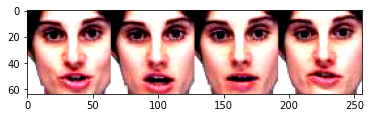

In [ ]:
plt.imshow(0.5 + tmp.permute(1, 2, 0)/2)